# Analysis of how much data shuffling affects learning curves

In [68]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from scipy.stats import iqr
from glob import glob

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/vol/ml/apartin/projects/LearningCurves/notebooks


In [66]:
from fit import * # weighted_power_law, fit_weighted_pwr_law
import rpy2.robjects as robjects

In [64]:
def calc_gof(y, yfit):
    gof = {}
    rmse = sqrt( metrics.mean_squared_error(y, yfit) )
    mae = metrics.mean_absolute_error(y, yfit)
    gof['rmse'] = rmse
    gof['mae'] = mae
    return gof

In [76]:
# Set Y axis
def set_yticks_ap(ax, ylim=None):
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if (ylim is None):
        ylim = ax.get_ylim()
    ylim_log = np.log2(ylim)
    ylabels_log = np.logspace(ylim_log[0], ylim_log[1], num=5, base=2)
    ylabels_log = np.around(ylabels_log, decimals=3)
    ax.set_yticks(ylabels_log)
    return ax

### Load results from runs

In [2]:
# src = 'gdsc'
src = 'top6'

# GDSC
if src == 'gdsc':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_100_trees')

elif src == 'top6':    
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_none/nn_reg0')
    
elif src == 'ctrp':
    pass
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_100_trees')
    
elif src == 'top21':
    pass
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top21/multi_seed_lgbm_100_trees/trn.top21/split_on_cell/')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees')
    
runs = glob(str(base_dir/'*'))

In [3]:
scores = []
# prf = 'id'
prf = 'run'

for i, r in enumerate(runs):
    # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists():
        continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': prf+str(i)}, inplace=True)
    if len(scores)==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])
        
run_col_names = [c for c in scores.columns if prf in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)
# scores_iqr    = iqr(scores.iloc[:, 6:].values, axis=0)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)
print(len(np.unique(scores.tr_size)))

# display(scores[:2])
print('Training set sizes:', np.unique(scores.tr_size))

# scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True)

save = True
if save:
    scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)
    scores_te.to_csv(base_dir/'scores.csv', index=False)

12
Training set sizes: [   128    256    512   1024   2048   4096   8192  16384  32768  65536
 131072 213015]


# LC all lin-lin

In [41]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

shift_idx=0
# shift_idx=1
# shift_idx=2
# shift_idx=3

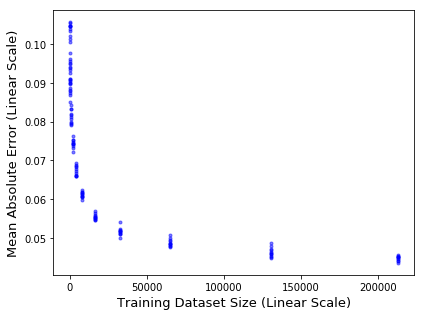

In [46]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'linear', 'ytick_scale': 'linear'}

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shift_idx, **plot_args );

ax.tick_params(axis='both', labelsize=11)
ax.grid(False)

plt.tight_layout()
plt.savefig(base_dir/(f'{src}_all_runs_linlin.png'), dpi=200)

# LC all log-log

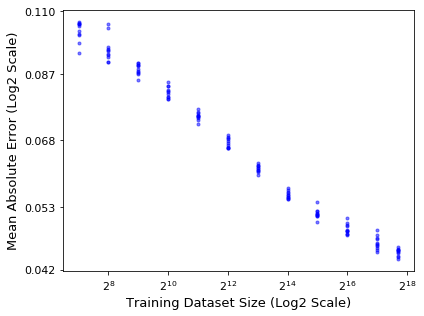

In [59]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shift_idx, **plot_args );

# print(ax.xaxis.get_major_locator())
# print(ax.yaxis.get_major_locator())
# print(ax.xaxis.get_major_formatter())
# print(ax.yaxis.get_major_formatter())

# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_all_runs_loglog.png'), dpi=200)

In [29]:
# Fit data
# pp_utils.fit_lc_multi_runs(runs, metric_name=metric_name, tr_set='te',
#                              shard_min_idx=shard_min_idx, cv_folds=1,
#                              xtick_scale=xtick_scale, ytick_scale=ytick_scale)

In [30]:
# x, y = get_xy(Path(runs[2]), metric_name='mean_absolute_error', tr_set='te', shard_min_idx=0, cv_folds=1)
# ax = lrn_crv_plot.plot_lrn_crv_power_law(x=x, y=y, marker='.', alpha=0.7)

# LC of Median and STD across shuffles

In [61]:
plot_args = {'metric_name': metric_name, 'xtick_scale': 'log2', 'ytick_scale': 'log2', 'figsize': figsize}

# The previous two figures should help decide which shards to use
scr = scores_te[shift_idx:].reset_index(drop=True)
y_col_name = 'median'

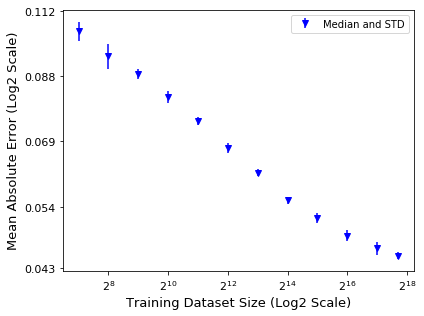

In [63]:
x = scr['tr_size']
y = scr[y_col_name]
yerr = scr['std']

shard_min_idx = 0
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD');
# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=10, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_avg_median_std.png'), dpi=200)

# Fit using all shards

GOF: {'rmse': 0.004373180294086962, 'mae': 0.002395415843374948}


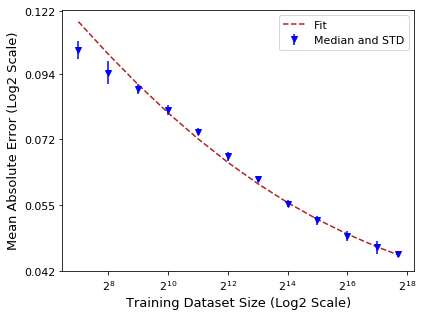

In [70]:
x = scr['tr_size']
y = scr[y_col_name]
yerr = scr['std']

shard_min_idx = 0
xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms)

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='firebrick', label='Fit')
gof = calc_gof(yf, yfit)
print('GOF:', gof)

# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_fit_using_all_shards.png'), dpi=200)

# Fit using subset of shards

GOF: {'rmse': 0.0010605317580562998, 'mae': 0.0005777380772490286}


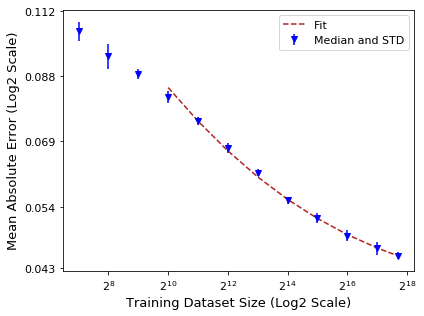

In [71]:
tot_pnts = len(x)
n_pnts_fit = 9 # Number of points to use for curve fitting starting from the largest size

x = scr['tr_size']
y = scr[y_col_name]
yerr = scr['std']

shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit

xf = x[shard_min_idx:]
yf = y[shard_min_idx:]
prms = fit_params(xf, yf)
yfit = biased_powerlaw(xf, **prms)

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD')

ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                   ax=ax, ls='--', marker='', alpha=1,
                                   **plot_args, color='firebrick', label='Fit')
gof = calc_gof(yf, yfit)
print('GOF:', gof)

# ---------------------
# General axes prms
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
ax.tick_params(axis='both', labelsize=11)

# Set X axis
xlim = ax.get_xlim()
# ax.set_xticks([2**i for i in range(2, 17)])

# Set Y axis
ax = set_yticks_ap(ax)

ax.legend(frameon=True, fontsize=11, loc='best');
ax.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_fit_using_subset_shards.png'), dpi=200)

# MAE vs Number of LC fit points

The workflow is to go backwards. We fit a power-law after every time we compute score for consecutive (smaller) shard. Stop when quality of fit decreases.

tot_pnts 12


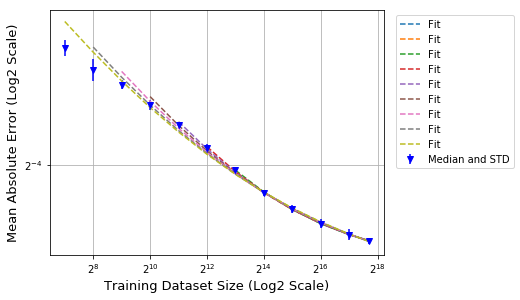

In [72]:
x = scr['tr_size']
y = scr[y_col_name]
yerr = scr['std']

tot_pnts = len(x)
print('tot_pnts', tot_pnts)
# min_points = 3  # 3 points doesn't work
min_pnts_fit = 4  # Min points to fit 
# max_pnts_fit = 9  # Min points to fit
max_pnts_fit = tot_pnts

p_arr = []
gof_arr = []
prm_arr = []

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(x=x, y=y, yerr=yerr,
                                   ax=ax, ls='', marker='v', alpha=1,
                                   **plot_args, color='b', label='Median and STD');

for n_pnts_fit in range(min_pnts_fit, max_pnts_fit+1):
    shard_min_idx = tot_pnts - n_pnts_fit
    
    xf = x[shard_min_idx:]
    yf = y[shard_min_idx:]
    prms = fit_params(xf, yf)
    yfit = biased_powerlaw(xf, **prms)
    
    gof = calc_gof(yf, yfit)
    
    ax = lrn_crv_plot.plot_lrn_crv_new(x=xf, y=yfit,
                                       ax=ax, ls='--', marker='', alpha=1,
                                       **plot_args, label='Fit');
    
    prm_arr.append(prms)
    gof_arr.append(gof)
    p_arr.append(n_pnts_fit)

In [73]:
prm_df = pd.DataFrame(prm_arr)
gof_df = pd.DataFrame(gof_arr)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, gof_df, prm_df], axis=1)

display(dd.sort_values('mae'))

,n_pnts,mae,rmse,alpha,beta,gamma
0,4,0.000020,0.000022,1.817221,-0.490068,0.040589
1,5,0.000086,0.000110,0.775024,-0.397441,0.039107
2,6,0.000116,0.000161,1.023745,-0.429027,0.039730
3,7,0.000217,0.000296,0.792903,-0.399311,0.039102
4,8,0.000328,0.000515,0.634937,-0.372404,0.038407
5,9,0.000578,0.001061,0.506571,-0.343907,0.037511
6,10,0.001040,0.001827,0.421395,-0.319702,0.036593
7,11,0.001640,0.003157,0.358260,-0.297485,0.035591
8,12,0.002395,0.004373,0.322473,-0.282537,0.034812


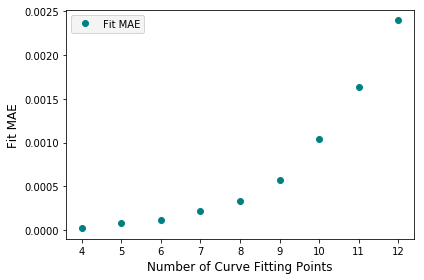

In [74]:
plot_beta = False
# plot_beta = True

fig, ax1 = plt.subplots()

# Plot metrics
alpha = 0.6
linewidth = 1
fontsize = 12
lns1 = ax1.plot(dd.n_pnts, dd.mae, marker='o', ls='', color='teal', label='Fit MAE');
ax1.set_xlabel('Number of Curve Fitting Points', fontsize=fontsize)
# ax1.set_xlabel('Number of points used to fit power-law model', fontsize=fontsize)
ax1.set_ylabel('Fit MAE', fontsize=fontsize)
ax1.tick_params('y', colors='k')

leg = lns1

if plot_beta:
    ax2 = ax1.twinx()
    lns2 = ax2.plot(dd.n_pnts, dd.beta, color='m', marker='*', ls='', label='Fit Parameter $b$')
    ax2.set_ylabel('Fit Parameter $b$ in $am^{b} + c$', color='k', fontsize=fontsize)
    ax2.tick_params('y', colors='k')
    leg.append(lns2)
    leg = lns1 + lns2
        
ax1.grid(True)

labs = [l.get_label() for l in leg]
legend = ax1.legend(leg, labs, loc=0)
frame = legend.get_frame()
frame.set_facecolor('0.95')

# ax.set_ylim([0.060, 0.150])
ax1.grid(False)
plt.tight_layout()
plt.savefig(base_dir/(f'{src}_mae_prm_b_num_points.png'), dpi=200)

### Aggregate results over runs

In [10]:
# scores = []
# for i, r in enumerate(runs):
#     dpath = Path(r)/'lrn_crv_scores.csv'
#     if not dpath.exists(): continue
        
#     scr_tmp = pd.read_csv( dpath )
#     scr_tmp.rename(columns={'fold0': 'run'+str(i+1)}, inplace=True)
#     if len(scores)==0:
#         scores = scr_tmp
#     else:
#         scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])
        
# run_col_names = [c for c in scores.columns if 'run' in c]

# scores_mean   = scores[run_col_names].mean(axis=1)
# scores_median = scores[run_col_names].median(axis=1)
# scores_std    = scores[run_col_names].std(axis=1)

# scores.insert(loc=3, column='mean', value=scores_mean)
# scores.insert(loc=3, column='median', value=scores_median)
# scores.insert(loc=3, column='std', value=scores_std)    

# scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)

### LC of mean and errorbars

In [31]:
figsize=(6, 4.5)
metric_name='mean_absolute_error'
xtick_scale, ytick_scale = 'linear', 'linear'
# xtick_scale, ytick_scale = 'log2', 'log2'

plot_kwargs = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

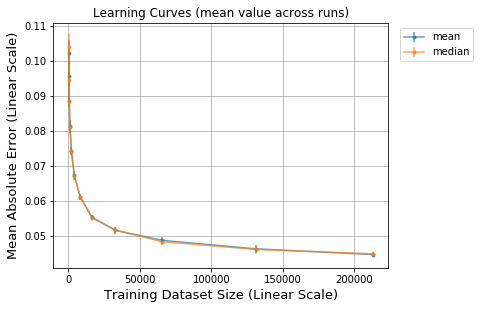

In [32]:
df = scores[ (scores['metric']==metric_name) & (scores['set']=='te') ].reset_index(drop=True)

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
            x=df['tr_size'], y=df['mean'], yerr=df['std'], ax=ax, marker='.', alpha=0.7,
            title='Learning Curves (mean value across runs)', **plot_kwargs, label='mean')

ax = lrn_crv_plot.plot_lrn_crv_new(
            x=df['tr_size'], y=df['median'], yerr=df['std'], ax=ax, marker='.', alpha=0.7,
            title='Learning Curves (mean value across runs)', **plot_kwargs, label='median')

### Fit power-law to LC of mean across shuffles

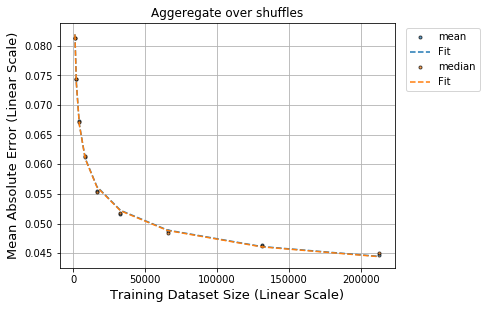

In [33]:
shard_min_idx = 3
ax, _, _ = lrn_crv_plot.plot_lrn_crv_power_law( x=df['tr_size'][shard_min_idx:], y=df['mean'][shard_min_idx:], title='Aggeregate over shuffles', **plot_kwargs, label='mean' );
ax, _, _ = lrn_crv_plot.plot_lrn_crv_power_law( x=df['tr_size'][shard_min_idx:], y=df['median'][shard_min_idx:], title='Aggeregate over shuffles', **plot_kwargs, label='median', ax=ax );

### Plot score deviation (std) vs shard across shuffles

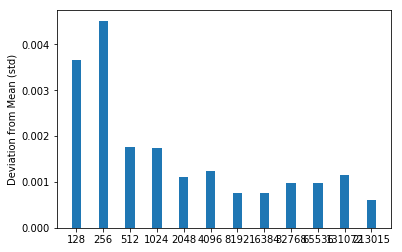

In [34]:
# matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html#sphx-glr-gallery-lines-bars-and-markers-bar-stacked-py
y_err = df['std'].values
ind = np.arange(len(y_err))
width = 0.35  # width of the bars

p1 = plt.bar(ind, y_err, width)
plt.ylabel('Training Set Size')
plt.ylabel('Deviation from Mean (std)') # TODO: should we use a different metric which is more robust to outliers such as IQR?
plt.xticks(ind, [str(sz) for sz in df['tr_size'].values])
plt.show()

# Compare ML models from multi-seed runs

In [28]:
def filter_scores(scores):
    return scores[ (scores['metric']==metric_name) & (scores['set']=='te') ].reset_index(drop=True)

In [119]:
# GDSC
# dir1 = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_100_trees_no_hpo')
# dir2 = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_1000_trees_no_hpo')
# dir3 = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_100_trees_no_hpo')
# dir4 = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_1000_trees_no_hpo')

dir1 = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_100_trees')
dir3 = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_100_trees')

# CTRP
# dir1 = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees_no_hpo')
# dir2 = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_1000_trees_no_hpo')
# dir3 = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_100_trees_no_hpo')
# dir4 = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_1000_trees_no_hpo')

# dir1 = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees')
# dir3 = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_100_trees')

In [120]:
df1 = filter_scores( pd.read_csv(dir1/'all_seed_runs_scores.csv') )
# df2 = filter_scores( pd.read_csv(dir2/'all_seed_runs_scores.csv') )
df3 = filter_scores( pd.read_csv(dir3/'all_seed_runs_scores.csv') )
# df4 = filter_scores( pd.read_csv(dir4/'all_seed_runs_scores.csv') )

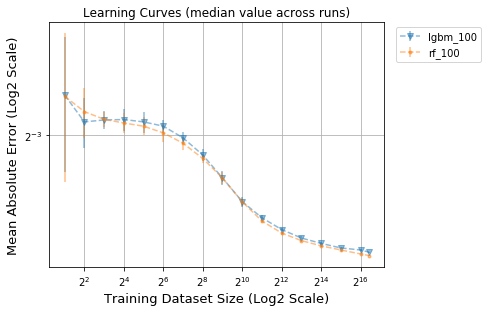

In [121]:
figsize=(6,4.5)
metric_name='mean_absolute_error'
# xtick_scale, ytick_scale = 'linear', 'linear'
xtick_scale, ytick_scale = 'log2', 'log2'

plot_kwargs = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
            x=df1['tr_size'], y=df1['median'], yerr=df1['std'], ax=ax, marker='v', ls='--', alpha=0.5,
            title='Learning Curves (median value across runs)', **plot_kwargs, label='lgbm_100')

# ax = lrn_crv_plot.plot_lrn_crv_new(
#             x=df2['tr_size'], y=df2['median'], yerr=df2['std'], ax=ax, marker='v', alpha=0.5,
#             title='Learning Curves (median value across runs)', **plot_kwargs, label='lgbm_1000')

ax = lrn_crv_plot.plot_lrn_crv_new(
            x=df3['tr_size'], y=df3['median'], yerr=df3['std'], ax=ax, marker='.', ls='--', alpha=0.5,
            title='Learning Curves (median value across runs)', **plot_kwargs, label='rf_100')

# ax = lrn_crv_plot.plot_lrn_crv_new(
#             x=df4['tr_size'], y=df4['median'], yerr=df4['std'], ax=ax, marker='.', alpha=0.5,
#             title='Learning Curves (median value across runs)', **plot_kwargs, label='rf_1000')